In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import time,sys

def ProgressBar(total, progress):
    """ ProgressBar - Displays or updates a console progress bar.
    ######################     EXAMPLE     ######################
    
    runs = 300
    for run_num in range(runs):
        time.sleep(.1)
        ProgressBar(runs, run_num + 1)
        
    #############################################################
    Original source: https://stackoverflow.com/a/15860757/1391441
    """
    barLength, status = 20, ""
    progress = float(progress) / float(total)
    if progress >= 1.:
        progress, status = 1, "\r\n"
    block = int(round(barLength * progress))
    text = "\r[{}] {:.0f}% {}".format(
        "#" * block + "-" * (barLength - block), round(progress * 100, 0),
        status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [3]:
def sigmoid(x):
    """
    The sigmoid activation function.
    """
    return 1 / (1 + np.exp(-x))
    
def delsigmoid(x):
    """
    The first derivative of the sigmoid function wrt x
    """
    return np.exp(x) / (1 + np.exp(x))**2

def deltanh(x):
    """
    The first derivative of the tanh function wrt x
    """
    return 1-np.tanh(x)**2

def relu(x):
    """
    Linear rectifier returns x if bigger than 0.5
    """
    return np.where(x>=0, x, 0)

def delrelu(x):
    """
    The first derivative of the relu function wrt x
    """
    return np.where(x>=0, 1, 0)

def activ(which, x):
    """
    Using desired activation function
    """
    if which == "sigmoid":
        func = sigmoid(x)
    elif which == "hyper":
        func = np.tanh(x)
    elif which == "relu":
        func = relu(x)
    else:
        print("False NAME!!!")
        
    return func

def delactiv(which, x):
    """
    Using desired derivative of activation function
    """
    if which == "sigmoid":
        func = delsigmoid(x)
    elif which == "hyper":
        func = deltanh(x)
    elif which == "relu":
        func = delrelu(x)
    else:
        print("False NAME!!!")
        
    return func

In [4]:
def xor_net(inputs, weights, activ_func):
    """
    A single forward pass through the network.
    Implementation of wX + b
    """
    which = activ_func
    
    num_inputs = 2 
    num_hidden = 2
    num_output = 1
    
    weights_01 = np.zeros((num_inputs, num_hidden))
    weights_12 = np.zeros((num_hidden, num_output))
    
    weights_01[0,0], weights_01[0,1] = weights[0], weights[1]
    weights_01[1,0], weights_01[1,1] = weights[2], weights[3]
    weights_12[0,0], weights_12[1,0] = weights[4], weights[5]
    
    b_01 = np.zeros((1,num_hidden))
    b_12 = np.zeros((1,num_output))
    
    b_01[0,0], b_01[0,1] = weights[6], weights[7]
    b_12[0,0] = weights[8]  # 4 weights from layer 0 to 1; 
                            # 2 weights from layer 1 to 2; 
                            # 2 biases from layer 0 to 1; 
                            # 1 bias from layer 1 to 2;
                            # 9 values in total

    hidden_in = np.dot(inputs, weights_01) + b_01
    hidden_out = activ(which, hidden_in)

    output_in = np.dot(hidden_out, weights_12) + b_12
    output_out = activ(which, output_in)

    return hidden_in[0], hidden_out[0], output_in[0][0], output_out[0][0]

def mse(weights, activ_func):
    """
    Creates an XOR network with given weights for all four input vectors
    and computes the mean square error for all of them
    """
    pred_00 = xor_net([0,0], weights[0], activ_func)[-1]
    pred_01 = xor_net([0,1], weights[1], activ_func)[-1]
    pred_10 = xor_net([1,0], weights[2], activ_func)[-1]
    pred_11 = xor_net([1,1], weights[3], activ_func)[-1]
    
    err = np.array([pred_00-0, pred_01-1, pred_10-1, pred_11-0])
    
    ms_err = np.mean(err**2)
    
    return ms_err

def grdmse(weights, activ_func):
    """
    Backward propagation to change of weights
    """
    which = activ_func
    
    HIN = np.zeros((4,2))
    HOUT = np.zeros((4,2))
    OIN = np.zeros(4)
    OOUT = np.zeros(4)    
    DIFF = np.zeros(4)
    for i in range(4):
        point = points[i]
        pred = xor_net(point, weights[i], which)[-1]
        diff = pred - result[i]
        hin, hout, oin, oout = xor_net(point, weights[i], which)
        DIFF[i], HIN[i], HOUT[i], OIN[i], OOUT[i] = diff, hin, hout, oin, oout
    
    dw9 = delactiv(which, OIN)
    
    d_b_l1 = dw9*(weights[:, 4:6]*delactiv(which, HIN)).T
    dw8, dw7 = d_b_l1[1], d_b_l1[0]
    
    d_w_l2 = dw9*HOUT.T
    dw5, dw6 = d_w_l2[0], d_w_l2[1]
    
    d_w_l1_c = dw9*(weights[:, 4:6]*delactiv(which, HIN)).T
    d_w1, d_w0 = d_w_l1_c[1]*points.T, d_w_l1_c[0]*points.T
    dw4, dw3 = d_w1[1], d_w1[0]
    dw2, dw1 = d_w0[1], d_w0[0]
    
    d_z = np.array([dw1, dw2, dw3, dw4, dw5, dw6, dw7, dw8, dw9])
    
    d_w = (d_z*DIFF).T
    
    return d_w

def classify(num):
    """
    classify the predicted outcome to 0 or 1
    """
    return np.where(num > 0.5, 1, 0)

def train(weights, activ_func, iteration, lr):
    """
    train the network based on given 4 points
    """
    MSE = []
    Misclass = []
    
    for i in range(iteration):
        grd = grdmse(weights, activ_func)
        weights = weights - lr*grd
    
        Mse = mse(weights, activ_func)
        MSE.append(Mse)
        
        d_00 = classify(xor_net([0,0], weights[0], activ_func)[-1])-0
        d_01 = classify(xor_net([0,1], weights[1], activ_func)[-1])-1
        d_10 = classify(xor_net([1,0], weights[2], activ_func)[-1])-1
        d_11 = classify(xor_net([1,1], weights[3], activ_func)[-1])-0
    
        p_r = np.array([d_00, d_01, d_10, d_11])
        misclass = len(np.where(p_r!=0)[0])
        Misclass.append(misclass)
        
    return MSE, Misclass, weights

In [35]:
points = np.array([[0,0], [0,1], [1,0], [1,1]])
result = np.array([0,1,1,0])
weights = np.repeat([np.random.uniform(size = 9)], [4], axis=0)
iteration = 1000

mse_sig, misclass_sig, weights_sig = train(weights, "sigmoid", iteration, 0.01)

RESULT_sig = np.zeros(4)
for i in range(4):
    prediction = xor_net(points[i], weights_sig[i], "sigmoid")[-1]
    RESULT_sig[i] = prediction

final_result_sig = classify(RESULT_sig)

final_result_sig

mse_hyper, misclass_hyper, weights_hyper = train(weights, "hyper", iteration, 0.01)

RESULT_hyper = np.zeros(4)
for i in range(4):
    prediction = xor_net(points[i], weights_hyper[i], "hyper")[-1]
    RESULT_hyper[i] = prediction
    

final_result_hyper = classify(RESULT_hyper)

final_result_hyper

mse_relu, misclass_relu, weights_relu = train(weights, "relu", iteration, 0.01)

RESULT_relu = np.zeros(4)
for i in range(4):
    prediction = xor_net(points[i], weights_relu[i], "relu")[-1]
    RESULT_relu[i] = prediction

final_result_relu = classify(RESULT_relu)

final_result_relu

array([0, 1, 1, 0])

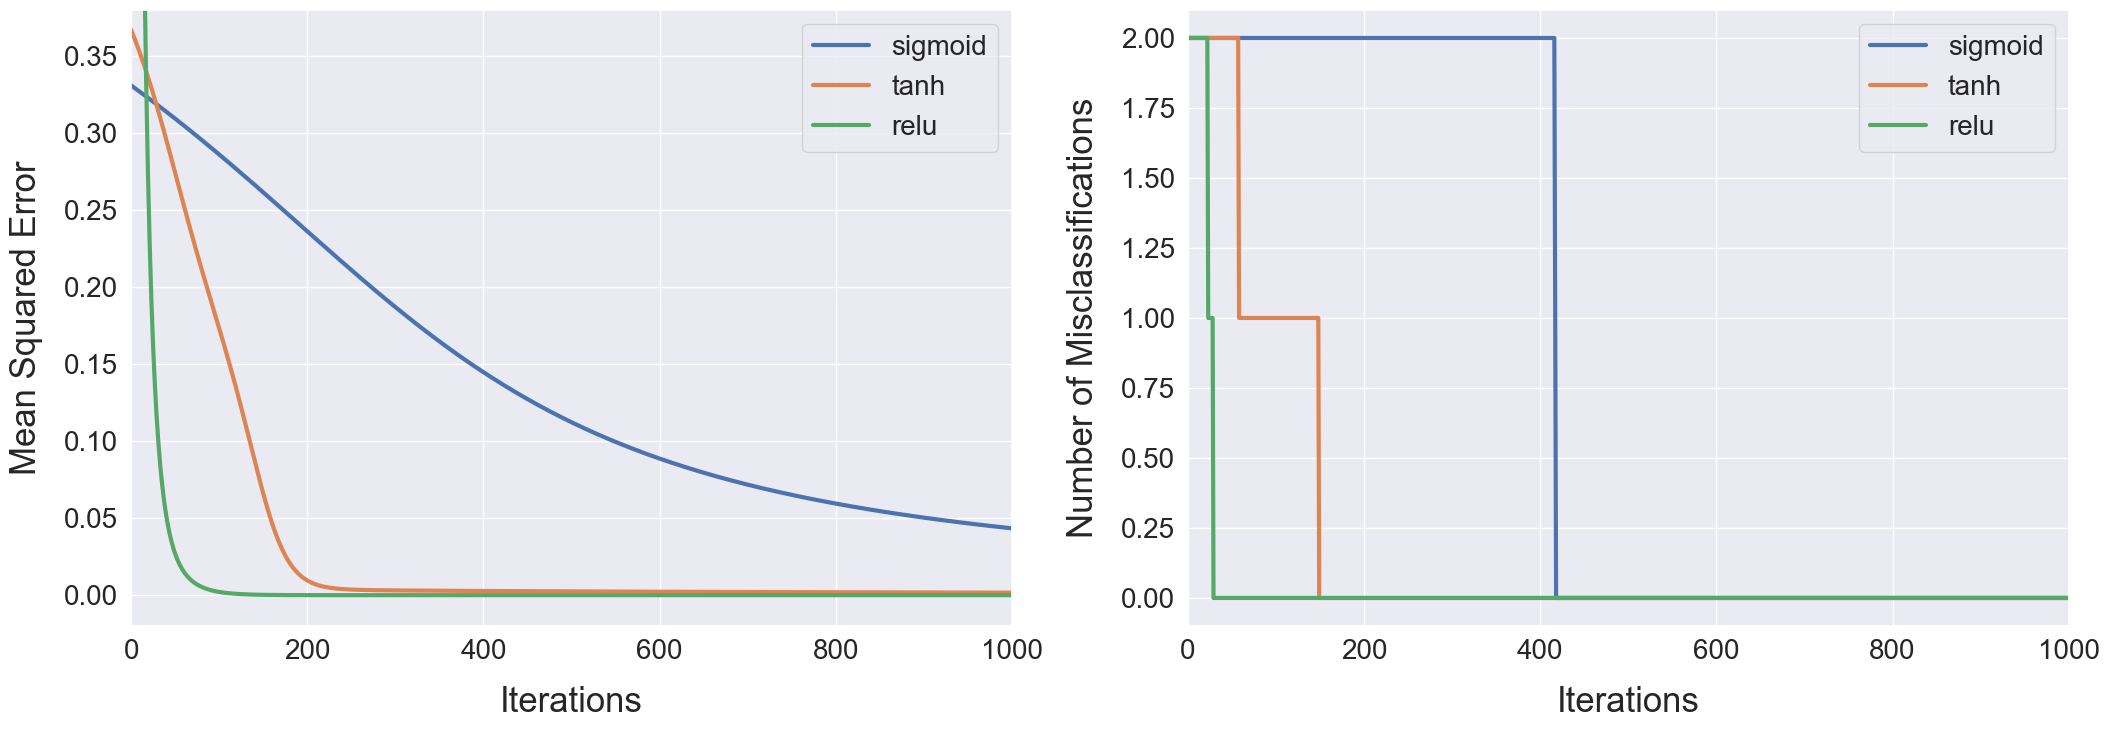

In [38]:
sns.set_theme(color_codes=True, style='darkgrid', rc={"lines.linewidth": 1})

steps = np.arange(0,iteration,1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,8))
ax[0].plot(steps, mse_sig, label='sigmoid', linewidth=3)
ax[0].plot(steps, mse_hyper, label='tanh', linewidth=3)
ax[0].plot(steps, mse_relu, label='relu', linewidth=3)
ax[1].plot(steps, misclass_sig, label='sigmoid', linewidth=3)
ax[1].plot(steps, misclass_hyper, label='tanh', linewidth=3)
ax[1].plot(steps, misclass_relu, label='relu', linewidth=3)
ax[0].set_xlabel('Iterations', fontsize=25, labelpad=15)
ax[1].set_xlabel('Iterations', fontsize=25, labelpad=15)
ax[0].set_ylabel('Mean Squared Error', fontsize=25, labelpad=15)
ax[1].set_ylabel('Number of Misclassifications', fontsize=25, labelpad=15)
ax[0].set_ylim(-0.02, 0.38)
ax[0].set_xlim(0, 1000)
ax[1].set_xlim(0, 1000)
ax[0].tick_params(axis='both', labelsize=20)
ax[1].tick_params(axis='both', labelsize=20)
ax[0].legend(prop={'size': 20})
ax[1].legend(prop={'size': 20})

In [88]:
def lazy_approach(points, results, iteration, activ_func):
    """
    Generate random weights to see how many iterations before correct classification
    """
    it_num = []
    for i in range(iteration):
        weights = np.repeat([np.random.randn(9)*80], [4], axis=0)
                     # larger range for the weights to ensure correct classification
        Pred = np.zeros(4)
        for j in range(4):
            point = points[j]
            pred = xor_net(point, weights[j], activ_func)[-1]
            Pred[j] = classify(pred)
        diff = np.abs(Pred-results)
        misclass = len(np.where(diff!=0)[0])
        if misclass == 0:
            count = sum(it_num)
            it_num.append(i-count)
            ProgressBar(iteration, i+1)
        
    it_num = np.array(it_num)
    print(it_num)
    
    avg_it = round(np.mean(np.array(it_num)), 3)
    print("The average number of iterations before correct classification using sigmoid is: "+str(avg_it))

In [89]:
it_num = lazy_approach(points, result, 1000000, "sigmoid")

[####################] 99% [ 1148    31  1547  2187  4872   518  1657   883  4597  2066  1177  1777
    86  7683  1149  1638  2115   388    33  1138   241  2190  2230  4301
   832   907  1564  2554   541    78  4920   407  3066   171   702  4396
   150  1272  2279  7136   689  4584   283  2434  2275    32  1370  1212
   502   426   417  1637  4330    91  2408  5679  1902   573  1641   256
  1010   320  4055  1051  1484  2423   217   498   969  2227  1295   810
   659   770  2675  2590   639  3705  2404  5196  4902   225  7388  2143
   265   550  3613  4399  2967  2580   413  3670  2365   242   150   227
   452  8507   366   329  3277   590    50 12531  4810   406   457   756
  2838  3783  4181   765  3132   439  1643  2794 11964  1215  1719   480
   780   683   752  6977     7  3757  1065  1255  7297   491  3632  5083
  4407 11290  1254   589   399  3406   870   425   400   541  1005  4629
  4134  1595  6299   224   189  1386   154    68  7502   426  1275   619
   187  4816  2249  2342

In [53]:
print(len(It_Num))
print("The average number of iterations before correct classification using relu is: "+str(avg_it))

93
The average number of iterations before correct classification using relu is: 2781.441
